In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas import concat
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.io as sio

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
startTime = datetime.now()

#### Valor del pip y comision a definir:

In [0]:
lots = 0.01
pip = 10000
pip_value = 1.1 *lots
round_cost = 5 *lots

In [0]:
df = pd.read_pickle('EURNOK.pkl')
df = df[['Close']]
df = df.dropna()

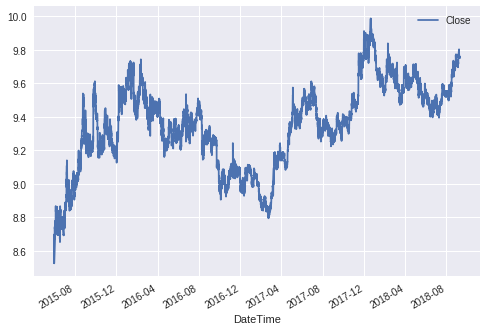

In [5]:
df.head(5)
df.plot()

#### Calculamos el ZScore

In [0]:
roll=[40, 60,90,180,252]
for paso in roll:
  mean = df.Close.rolling(paso).mean()
  std = df.Close.rolling(paso).std()
  df['zscore{}'.format(paso)] = (df.Close-mean)/std 

#### Backtest vectorizado

In [0]:
thresholds = []
pips = []
trades = []

cortes = [1.5, 1.8,2.1,2.4,2.7,3]
for score in roll:
  for corte in cortes:

    #Cuando ZScore cruce 0 devuelve 0
    df['Zero_X{}{}'.format(score,corte)] = np.where((df['zscore{}'.format(score)].shift() < 0) & (df['zscore{}'.format(score)] > 0),
                        0, np.where((df['zscore{}'.format(score)].shift() > 0) &
                                    (df['zscore{}'.format(score)] < 0), 0, 2))

    #Si Zscore cruza threshold, devuelve señal compra o venta
    df['position{}{}'.format(score,corte)] = np.where(df['zscore{}'.format(score)].shift() > corte, -1,
                          np.where(df['zscore{}'.format(score)].shift() < -corte, 1,
                                   np.where(df['Zero_X{}{}'.format(score,corte)].shift() == 0,
                                            0, np.nan)))
    
    df['position{}{}'.format(score,corte)].ffill(inplace=True)

    df['trades{}{}'.format(score,corte)] = np.where((df['position{}{}'.format(score,corte)].shift() == 0) &
                            (df['position{}{}'.format(score,corte)] != 0), 1, 0)

    df['sym_1_Return'] = np.log(df.iloc[:,0] / df.iloc[:,0].shift())
    Total_trades = df['trades{}{}'.format(score,corte)].sum()
    df['sym_1_profit{}{}'.format(score,corte)] = (df.sym_1_Return * df['position{}{}'.format(score,corte)])
    df['cumulative_pips{}{}'.format(score,corte)] = (np.cumsum(df['sym_1_profit{}{}'.format(score,corte)])*pip)
    """
    Total_pips_1 = df['cumulative_pips{}{}'].iloc[-1]
    pips_trade_1 = Total_pips_1/Total_trades
    
    thresholds.append(i)
    pips.append(pips_trade_1)
    trades.append(Total_trades)
    """

In [8]:
df.columns

Index(['Close', 'zscore40', 'zscore60', 'zscore90', 'zscore180', 'zscore252',
       'Zero_X401.5', 'position401.5', 'trades401.5', 'sym_1_Return',
       ...
       'Zero_X2522.7', 'position2522.7', 'trades2522.7', 'sym_1_profit2522.7',
       'cumulative_pips2522.7', 'Zero_X2523', 'position2523', 'trades2523',
       'sym_1_profit2523', 'cumulative_pips2523'],
      dtype='object', length=157)

In [9]:
scores = [n for n in df.filter(like='sym_1_profit',axis=1).columns]
scores


['sym_1_profit401.5',
 'sym_1_profit401.8',
 'sym_1_profit402.1',
 'sym_1_profit402.4',
 'sym_1_profit402.7',
 'sym_1_profit403',
 'sym_1_profit601.5',
 'sym_1_profit601.8',
 'sym_1_profit602.1',
 'sym_1_profit602.4',
 'sym_1_profit602.7',
 'sym_1_profit603',
 'sym_1_profit901.5',
 'sym_1_profit901.8',
 'sym_1_profit902.1',
 'sym_1_profit902.4',
 'sym_1_profit902.7',
 'sym_1_profit903',
 'sym_1_profit1801.5',
 'sym_1_profit1801.8',
 'sym_1_profit1802.1',
 'sym_1_profit1802.4',
 'sym_1_profit1802.7',
 'sym_1_profit1803',
 'sym_1_profit2521.5',
 'sym_1_profit2521.8',
 'sym_1_profit2522.1',
 'sym_1_profit2522.4',
 'sym_1_profit2522.7',
 'sym_1_profit2523']

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


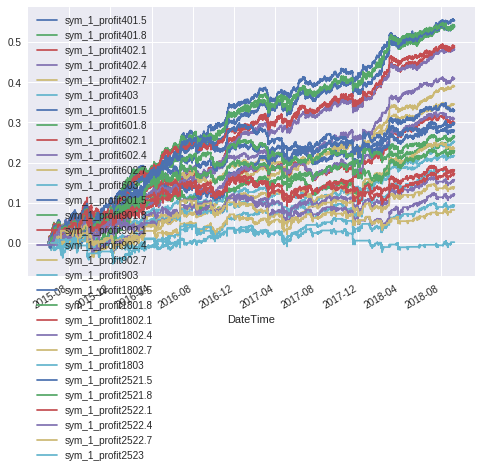

In [16]:
df[scores].fillna(0,inplace=True)
df[scores].cumsum().plot()

In [0]:
for item in  scores:
  nombre=  item + '€'
  df[nombre]=np.exp(df[item].cumsum())

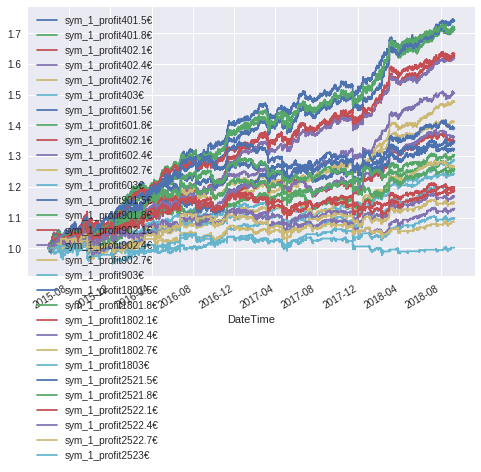

In [19]:
scores = [n for n in df.filter(like='€',axis=1).columns]
scores
df[scores].plot()

In [0]:
for item in roll:
  for corte in cortes:
    df['cumulative_dolars{}{}'.format(item,corte)] = (np.cumsum(df['sym_1_profit{}{}€'.format(item,corte)])*pip)*pip_value

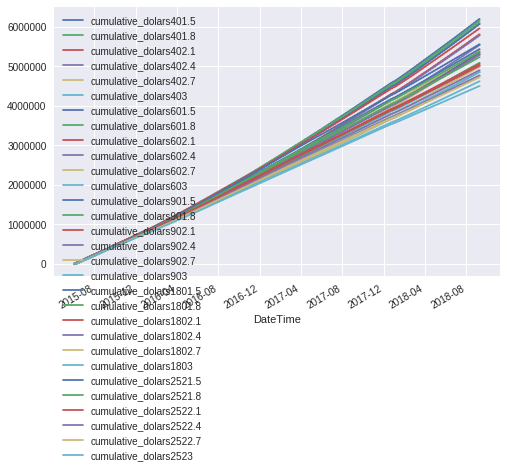

In [22]:
scores = [n for n in df.filter(like='cumulative_dol',axis=1).columns]
scores
df[scores].plot()

In [0]:
import matplotlib.pyplot as plt

#### Pips trade vs threshold

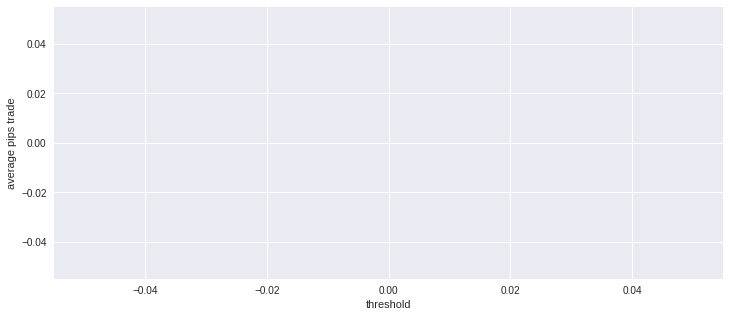

In [11]:
plt.figure(figsize=(12,5))
plt.xlabel('threshold')
plt.ylabel('average pips trade')
plt.plot(thresholds, pips, color='r', label='pips trade')
plt.show()

#### Num trades vs threshold

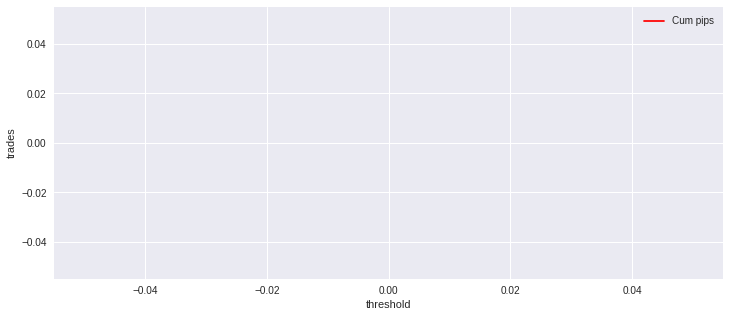

In [12]:
plt.figure(figsize=(12,5))
plt.xlabel('threshold')
plt.ylabel('trades')
plt.plot(thresholds, trades, color='r',  label='Cum pips')
plt.legend()
plt.show()

In [13]:
df['cumulative_dolars'] = (np.cumsum(df.sym_1_profit)*pip)*pip_value

AttributeError: ignored

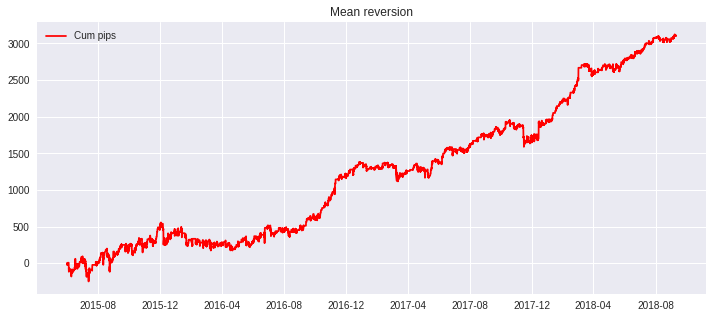

In [12]:
plt.figure(figsize=(12,5))
index = df.index.to_pydatetime()
plt.title('Mean reversion')
plt.plot(index, df['cumulative_pips'].values, color='r', label='Cum pips')
plt.legend()
plt.show()

In [13]:
print('Total trades is: ', Total_trades)

Total trades is:  553


In [14]:
print('Average pips trade: ', float("{0:.2f}".format(pips_trade_1)))

Average pips trade:  5.61


In [15]:
print(datetime.now() - startTime)

0:00:10.666759
